## San Sebastian Passengers Prediction

This notebook is an ML project in collaboration with Hupi company. The goal is to predict the number of passengers in the San Sebastian bus network.


In [54]:
import calendar
import os
import pickle

import holidays
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil.easter import easter
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from vacances_scolaires_france import SchoolHolidayDates
from xgboost import XGBRegressor

sns.set_theme(style="whitegrid")
RANDOM_STATE = 42

### Data Loading


In [55]:
dataset_path = os.path.join(os.getcwd(), "data", "data_passagers.csv")
df = pd.read_csv(dataset_path, parse_dates=["dateTime"])
df.describe()

,dateTime,weather,lineNumber,passengersNumber
count,37621,37621.000000,37621.000000,37621.000000
mean,2021-03-16 21:38:15.728449536,24.010579,31.744903,2067.940990
min,2019-04-05 00:00:00,11.000000,5.000000,1.000000
25%,2020-01-24 00:00:00,13.000000,17.000000,365.000000
50%,2021-06-19 00:00:00,24.000000,28.000000,1241.000000
75%,2022-04-05 00:00:00,26.000000,38.000000,2558.000000
max,2023-03-19 00:00:00,62.000000,110.000000,16124.000000
std,NaN,11.734847,23.335248,2494.733418


In [56]:
df.head()

,dateTime,weather,lineNumber,passengersNumber,lineType
0,2019-04-05,26,29,3032,daily
1,2019-04-05,26,42,418,daily
2,2019-04-05,26,40,2065,daily
3,2019-04-05,26,104,115,night
4,2019-04-05,26,27,2900,daily


### Data Visualization


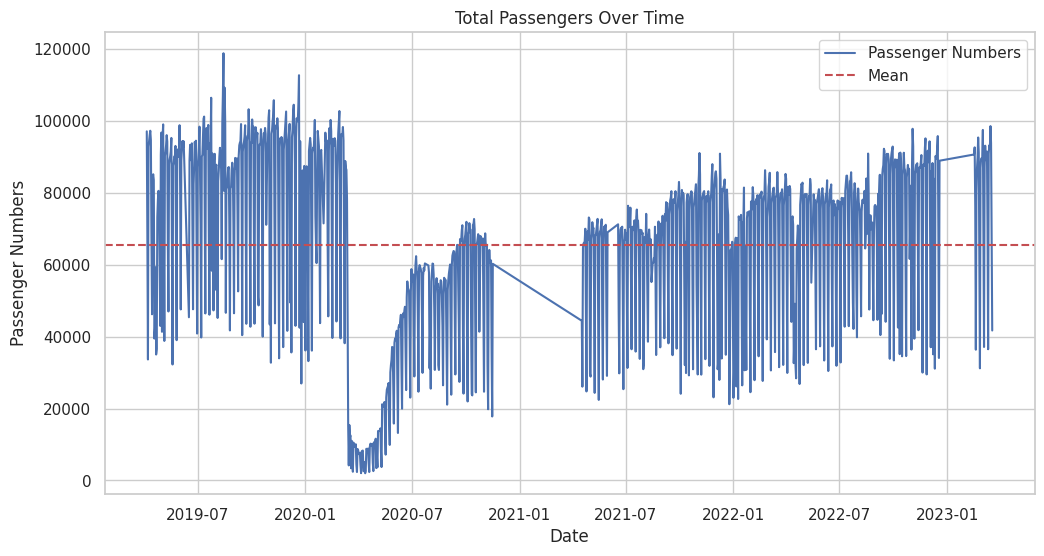

In [57]:
# Aggregate passenger numbers by date
daily_passengers = df.groupby("dateTime")["passengersNumber"].sum()

mean = daily_passengers.mean()

# Plot passenger numbers over time
plt.figure(figsize=(12, 6))
plt.plot(daily_passengers)
plt.axhline(mean, color="r", linestyle="--")
plt.title("Total Passengers Over Time")
plt.xlabel("Date")
plt.ylabel("Passenger Numbers")
plt.legend(["Passenger Numbers", "Mean"])
plt.show()

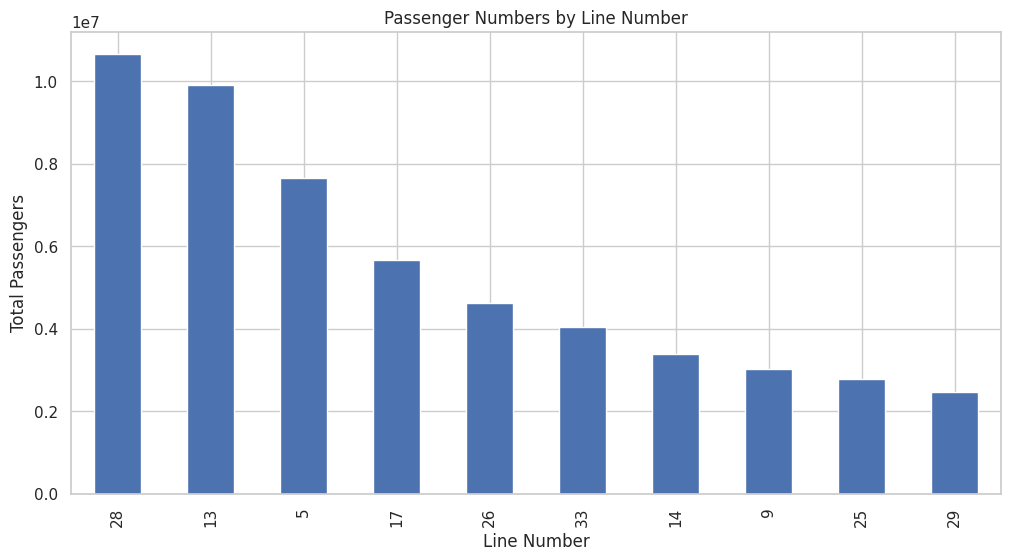

In [58]:
# Top Most used bus lines
line_passengers = (
    df.groupby("lineNumber")["passengersNumber"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

line_passengers.plot(kind="bar", figsize=(12, 6))
plt.title("Passenger Numbers by Line Number")
plt.xlabel("Line Number")
plt.ylabel("Total Passengers")
plt.show()

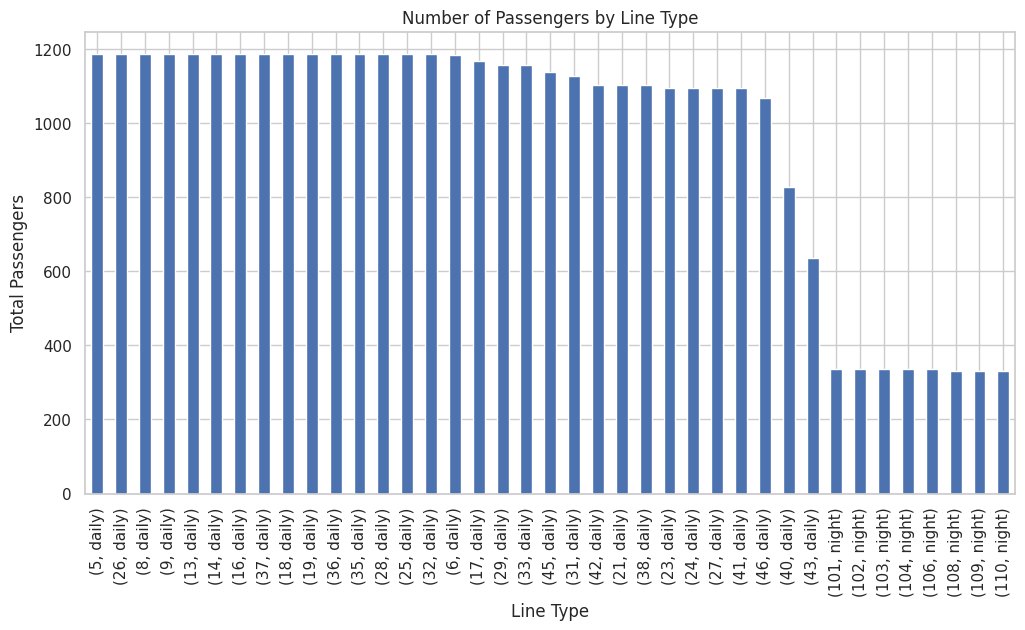

In [59]:
df[['lineNumber', 'lineType']].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title("Number of Passengers by Line Type")
plt.xlabel("Line Type")
plt.ylabel("Total Passengers")
plt.show()


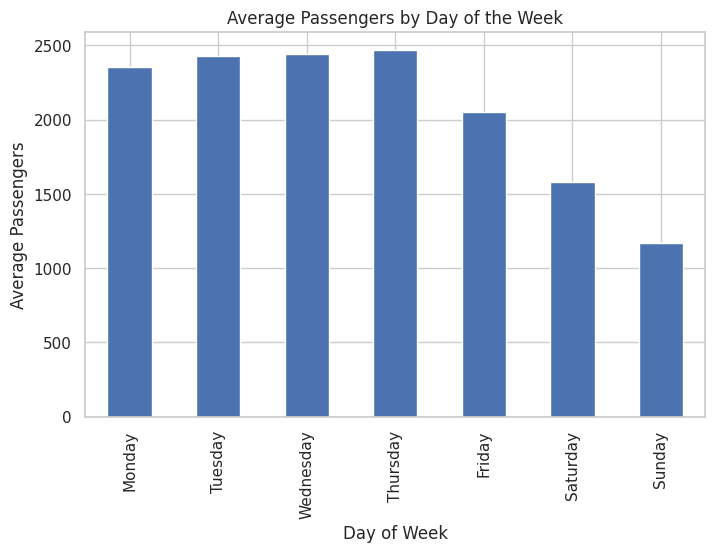

In [60]:
# Average passengers per day of the week
passengers_by_dow = df.groupby(df["dateTime"].dt.dayofweek)["passengersNumber"].mean()

passengers_by_dow.plot(kind="bar", figsize=(8, 5))
plt.title("Average Passengers by Day of the Week")
plt.xlabel("Day of Week")
# 0 is monday
plt.xticks(
    ticks=range(7),
    labels=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)
plt.ylabel("Average Passengers")
plt.show()

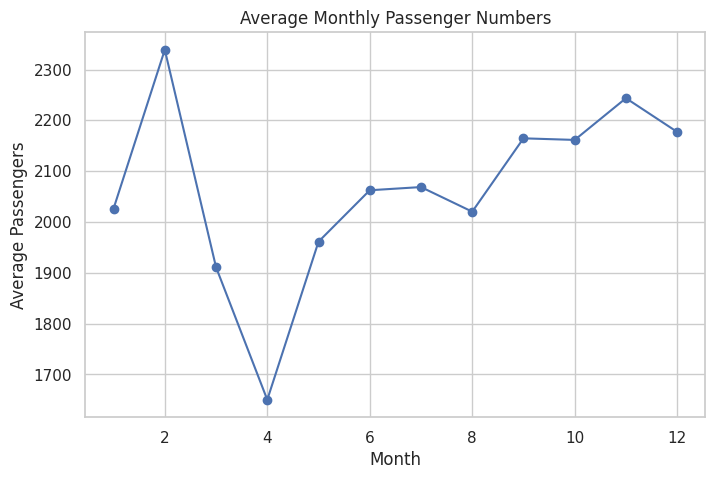

In [61]:
# Aggregate passengers by month
monthly_passengers = df.groupby(df["dateTime"].dt.month)["passengersNumber"].mean()

# Plot
monthly_passengers.plot(kind="line", marker="o", figsize=(8, 5))
plt.title("Average Monthly Passenger Numbers")
plt.xlabel("Month")
plt.ylabel("Average Passengers")
plt.show()

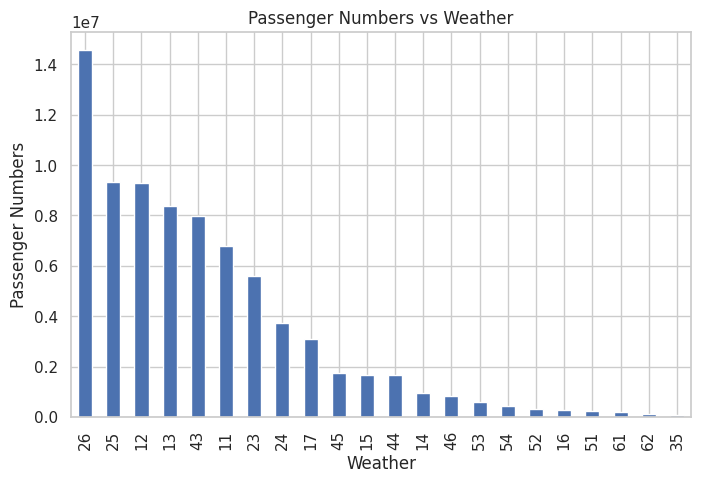

In [62]:
# Most freuqent weather type
passengers_by_weather = (
    df.groupby("weather")["passengersNumber"].sum().sort_values(ascending=False)
)
passengers_by_weather.plot(kind="bar", figsize=(8, 5))
plt.title("Passenger Numbers vs Weather")
plt.xlabel("Weather")
plt.ylabel("Passenger Numbers")
plt.show()

In [63]:
# Percentage of missing values
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)

dateTime            0.0
weather             0.0
lineNumber          0.0
passengersNumber    0.0
lineType            0.0
dtype: float64


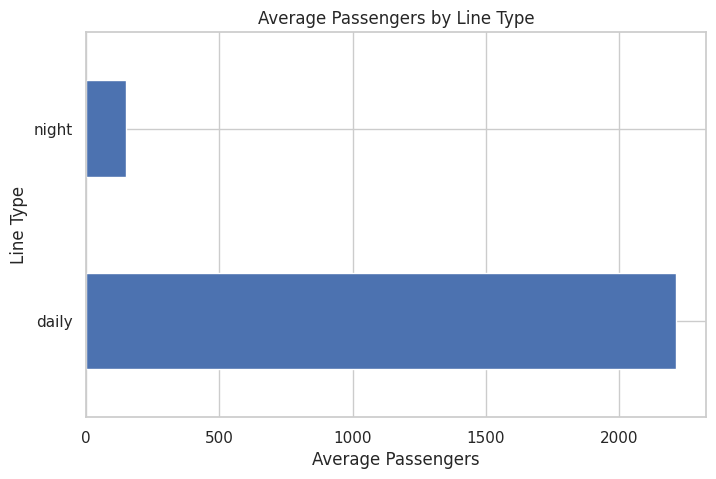

In [64]:
# Group by line type
line_type_passengers = df.groupby("lineType")["passengersNumber"].mean()

line_type_passengers.index = ["daily", "night"]

# Plot horizontal bar chart
line_type_passengers.plot(kind="barh", figsize=(8, 5))
plt.title("Average Passengers by Line Type")
plt.xlabel("Average Passengers")
plt.ylabel("Line Type")
plt.show()

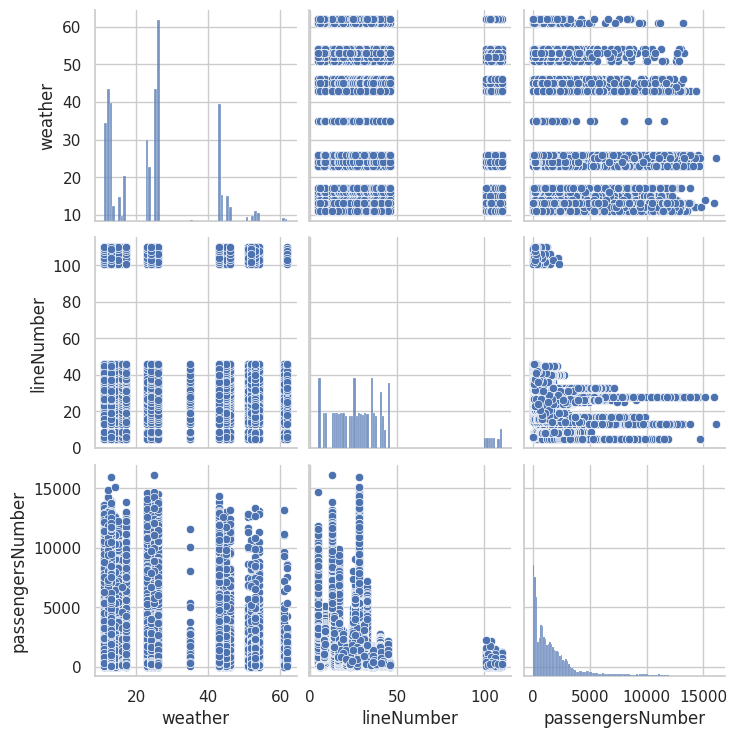

In [65]:
sns.pairplot(df)

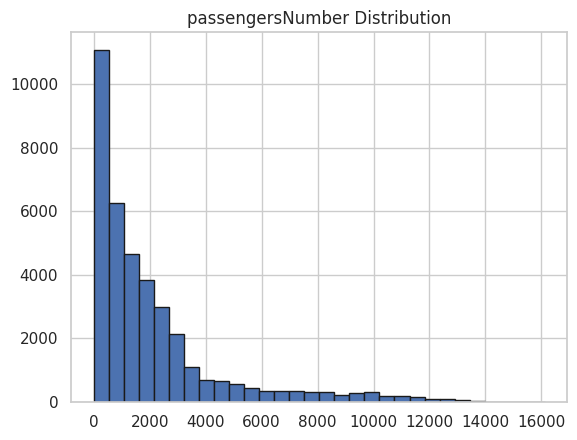

In [66]:
# Visualize the target variable
plt.hist(df["passengersNumber"], bins=30, edgecolor="k")
plt.title("passengersNumber Distribution")
plt.show()

#### Observation

passengersNumber is highly skewed


In [67]:
def plot_transformations(data, figsize=(15, 10)):
    """
    Plot original data and various transformations to compare their distributions.

    Parameters:
    data: array-like
        The input data to transform
    figsize: tuple
        Figure size for the plot
    """
    # Create transformations
    transformations = {
        "Original": data,
        "Log1p": np.log1p(data),
        "Square Root": np.sqrt(data),
        "Cube Root": np.cbrt(data),
        "Box-Cox": stats.boxcox(data)[0] if np.all(data > 0) else None,
        "Power (1/4)": np.power(data, 1 / 4),
    }

    # Calculate skewness for each transformation
    skewness = {
        name: stats.skew(trans)
        for name, trans in transformations.items()
        if trans is not None
    }

    # Create subplots
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    axes = axes.ravel()

    # Plot histograms
    for idx, (name, trans) in enumerate(transformations.items()):
        if trans is not None:
            axes[idx].hist(trans, bins=30, edgecolor="black")
            axes[idx].set_title(f"{name}\nSkewness: {skewness[name]:.3f}")
            axes[idx].grid(True)

    plt.tight_layout()
    return skewness


def get_best_transformation(data):
    """
    Returns the best transformation based on skewness closest to 0
    """
    transformations = {
        "Original": data,
        "Log1p": np.log1p(data),
        "Square Root": np.sqrt(data),
        "Cube Root": np.cbrt(data),
        "Box-Cox": stats.boxcox(data)[0] if np.all(data > 0) else None,
        "Power (1/4)": np.power(data, 1 / 4),
    }

    skewness = {
        name: abs(stats.skew(trans))
        for name, trans in transformations.items()
        if trans is not None
    }

    return min(skewness.items(), key=lambda x: x[1])


Skewness values for each transformation:
Original: 2.124
Log1p: -0.665
Square Root: 0.919
Cube Root: 0.438
Box-Cox: -0.041
Power (1/4): 0.181

Best transformation: Box-Cox (absolute skewness: 0.041)


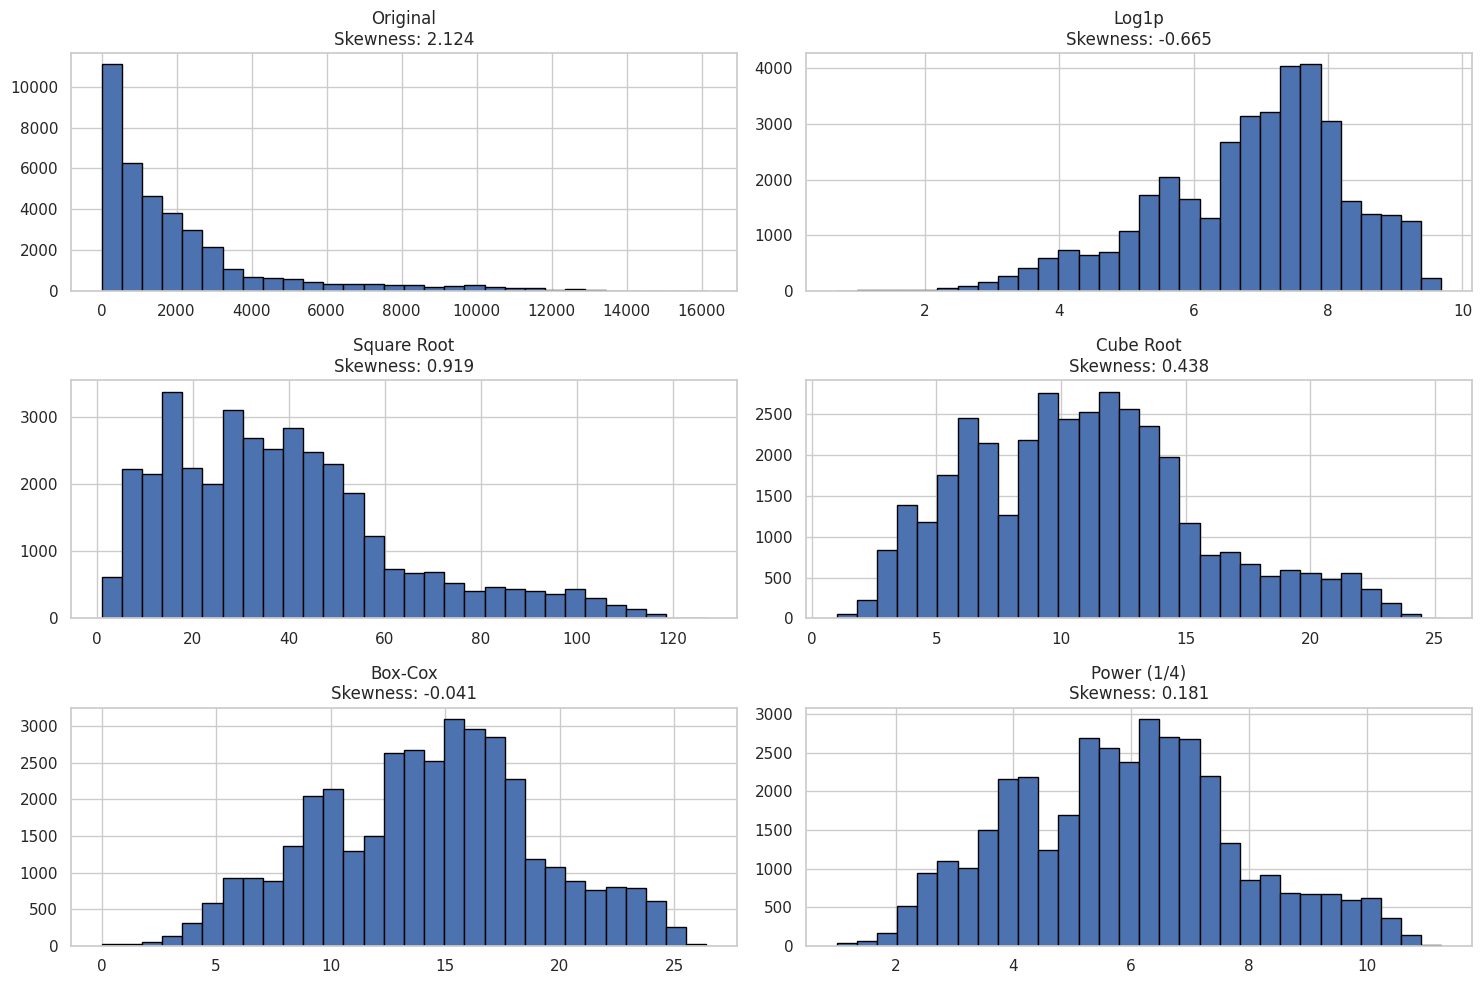

In [68]:
passengers = df["passengersNumber"]
skewness_results = plot_transformations(passengers)
best_transform, best_skewness = get_best_transformation(passengers)

print("\nSkewness values for each transformation:")
for transform, skew in skewness_results.items():
    print(f"{transform}: {skew:.3f}")

print(
    f"\nBest transformation: {best_transform} (absolute skewness: {best_skewness:.3f})"
)

### Feature Engineering


#### Temporal features


In [69]:
df["year"] = df["dateTime"].dt.year
df["day"] = df["dateTime"].dt.day
df["dayOfWeek"] = df["dateTime"].dt.dayofweek  # 0=Monday
df["dayOfYear"] = df["dateTime"].dt.dayofyear
df["isSunday"] = df["dateTime"].dt.dayofweek == 6
df["isWeekend"] = df["dateTime"].dt.dayofweek.isin([5, 6])

#### Event features


In [70]:
school_holiday_dates = SchoolHolidayDates()


def is_in_holy_week(date):
    easter_date = easter(date.year)
    palm_sunday = easter_date - pd.Timedelta(days=7)  # Start of Holy Week
    holy_saturday = easter_date - pd.Timedelta(days=1)  # End of Holy Week
    return palm_sunday <= date <= holy_saturday


df["isHoliday"] = df["dateTime"].dt.date.isin(holidays.ES(years=range(2019, 2024)))
df["isPaques"] = df["dateTime"].dt.date.apply(lambda x: x == easter(x.year))
df["isSchoolHoliday"] = df["dateTime"].dt.date.apply(school_holiday_dates.is_holiday)
df["isGrandSemaine"] = df["dateTime"].dt.date.apply(is_in_holy_week)

#### Target feature lagging


In [71]:
df["passengersNumberLag7"] = df["passengersNumber"].shift(7)
df["passengersNumberLag14"] = df["passengersNumber"].shift(14)
df["passengersNumberLag21"] = df["passengersNumber"].shift(21)

# Handle the first missing values by filling them with the mean of the column
df["passengersNumberLag7"] = df["passengersNumberLag7"].fillna(
    df["passengersNumberLag7"].mean()
)
df["passengersNumberLag14"] = df["passengersNumberLag14"].fillna(
    df["passengersNumberLag14"].mean()
)
df["passengersNumberLag21"] = df["passengersNumberLag21"].fillna(
    df["passengersNumberLag21"].mean()
)

#### Football matches

scrapped from https://www.les-sports.info/football-real-sociedad-resultats-identite-equ526.html


In [72]:
football_games_path = os.path.join(os.getcwd(), "data", "football_games.csv")
football_games_df = pd.read_csv(
    football_games_path, parse_dates=["Date"], dayfirst=True
)
football_games_df

,Date,equipe1,score,equipe2
0,2019-07-13,CD Lagun Onak (ESP),0 - 5,Real Sociedad San-Sebastian
1,2019-07-20,Racing Santander (ESP),1 - 0,Real Sociedad San-Sebastian
2,2019-07-26,Nottingham Forest (ANG),2 - 2,Real Sociedad San-Sebastian
3,2019-07-27,Real Sociedad San-Sebastian,3 - 3,Millwall (ANG)
4,2019-07-31,Deportivo Alavés (ESP),0 - 1,Real Sociedad San-Sebastian
...,...,...,...,...
221,2022-11-13,CD Cazalegas (ESP),1 - 4,Real Sociedad San-Sebastian
222,2022-12-21,CD Coria (ESP),0 - 5,Real Sociedad San-Sebastian
223,2023-01-04,UD Logroñés (ESP),0 - 1,Real Sociedad San-Sebastian
224,2023-01-17,Real Sociedad San-Sebastian,1 - 0,Real Majorque (ESP)


In [73]:
df["isFootballMatchDay"] = df["dateTime"].dt.date.isin(football_games_df["Date"].dt.date)
df[df['isFootballMatchDay']]['isFootballMatchDay'].sum()

5156

In [74]:
# finally drop the dateTime column
df.drop("dateTime", axis=1, inplace=True)

In [75]:
save_path = os.path.join(os.getcwd(), "data", "data_passagers_augmented.csv")
df.to_csv(path_or_buf=save_path, index=False)

### Model definition

For this project, we chose XGBoost for the following reasons

- XGBoost is a powerful and efficient implementation of the gradient boosting algorithm
- It is widely used in competitions and has proven to be very effective
- It can handle missing values and outliers
- It is robust to overfitting due to a wide selection of hyperparameters
- It can handle non-linear relationships


In [76]:
# Identify feature types
categorical_features = [
    "lineNumber",
    "lineType",
    "isSunday",
    "isWeekend",
    "isHoliday",
    "isPaques",
    "isSchoolHoliday",
    "isGrandSemaine",
    "isFootballMatchDay",
    "weather",
]

numerical_features = [
    "year",
    "day",
    "dayOfWeek",
    "dayOfYear",
    "passengersNumberLag7",
    "passengersNumberLag14",
    "passengersNumberLag21",
]

# Create transformers
numerical_transformer = StandardScaler()  # Scale numerical features
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore", sparse_output=False
)  # OneHotEncode categorical features

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),  # Preprocessing step
        ("model", XGBRegressor(random_state=RANDOM_STATE, verbosity=2)),  # Training step
    ]
)

#### Data Splitting

**NB** : We will use box-cox transformation to normalize the target feature


In [77]:
save_path = os.path.join(
    os.getcwd(), "data", "data_passagers_augmented.csv"
)
df_augmented = pd.read_csv(save_path)

df_augmented[df_augmented['isFootballMatchDay']]['isFootballMatchDay'].sum()

5156

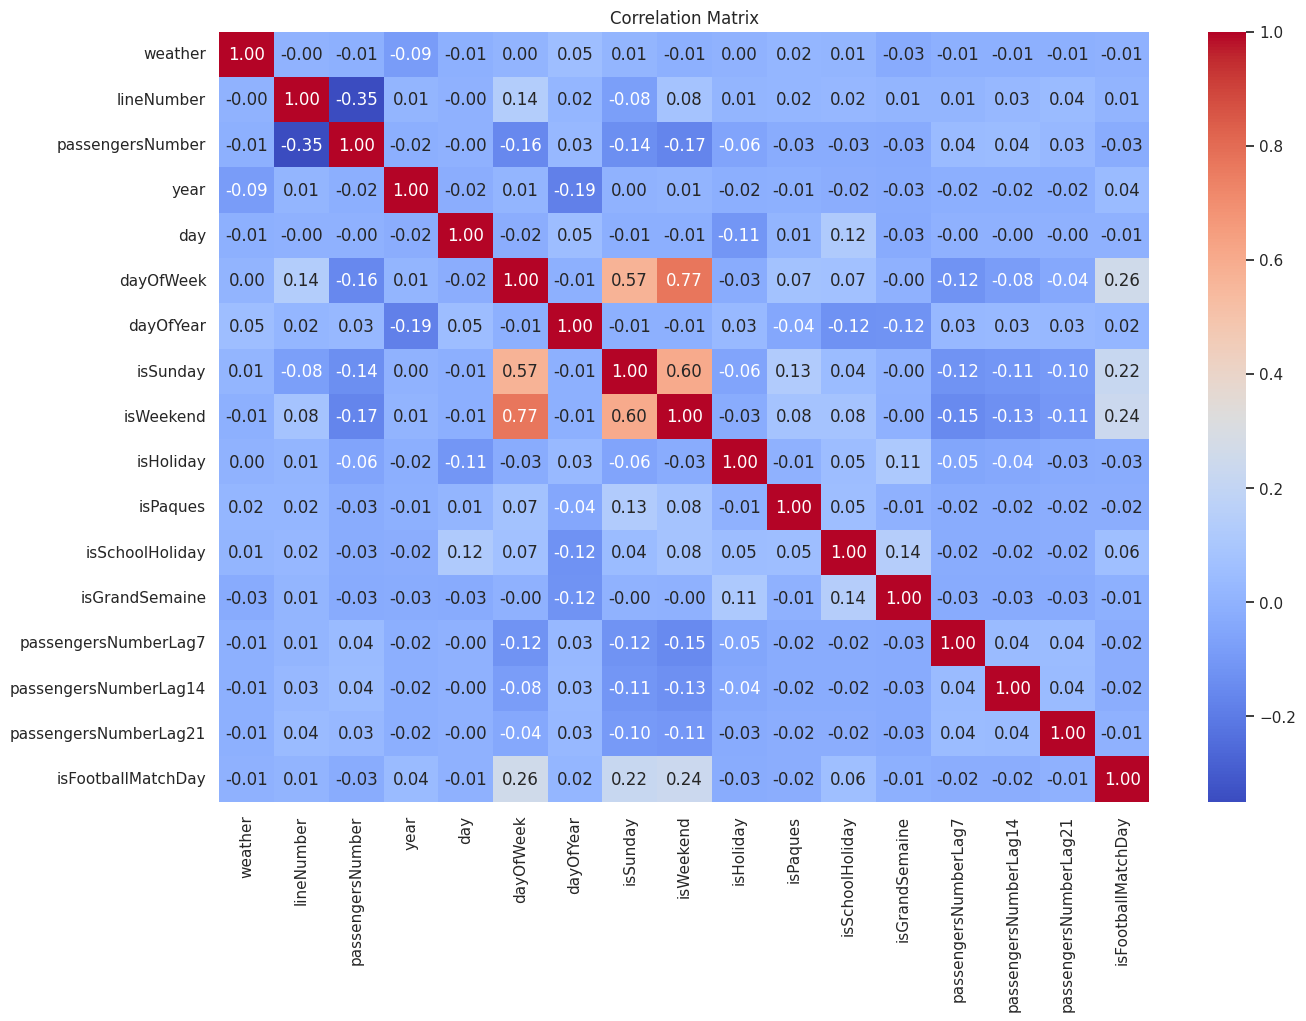

In [78]:
corr = df_augmented.drop(columns=['lineType']).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [79]:
target = "passengersNumber"

X = df_augmented.drop(columns=[target])
y = df_augmented[target]
y, lambda_boxcox = stats.boxcox(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Box-Cox Lambda:", lambda_boxcox)

X_train shape: (30096, 17)
X_test shape: (7525, 17)
y_train shape: (30096,)
y_test shape: (7525,)
Box-Cox Lambda: 0.18111186229030488


#### Hyperparameters tuning

In [80]:
# Define the hyperparameter grid
param_grid = {
    "model__learning_rate": [0.01, 0.1],        # Learning rate for gradient descent, higher values slow down convergence
    "model__n_estimators": [1000, 10000],       # Number of boosting rounds, 
    "model__max_depth": [3, 5, 12],             # Maximum depth of the tree, higher values can lead to overfitting
    "model__subsample": [0.8, 1],               # Fraction of samples to use in each boosting round
    "model__gamma": [0.1, 0.5],                 # Minimum loss reduction required to make a further partition
    "model__tree_method": ['hist', 'auto'],     # Fast histogram optimized approximate greedy algorithm
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=4,                               # 4-fold cross-validation
    n_jobs=-1,                          # Use all available CPUs for cross-validation
    scoring='neg_mean_squared_error',   # Using negative MAE as the scoring metric
    verbose=3,                          # To make the output verbose
    refit=True                          # Refit the best model on the entire dataset
)

In [81]:
# Fit the grid search with transformed y_train
grid_search.fit(X_train, y_train)

# create the model dir
os.makedirs("models", exist_ok=True)
grid_search_path = os.path.join(
    os.getcwd(), "models", "grid_search.pkl"
)

# Save the grid_search object
with open(grid_search_path, "wb") as file:
    pickle.dump(grid_search, file)

print(f"RandomizedSearchCV object saved to {grid_search_path}")

model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[CV 3/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=1000, model__subsample=0.8, model__tree_method=hist;, score=-2.766 total time=   6.1s
[CV 2/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=1000, model__subsample=0.8, model__tree_method=hist;, score=-2.773 total time=   6.1s
[CV 4/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=1000, model__subsample=0.8, model__tree_method=hist;, score=-2.791 total time=   6.3s
[CV 4/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=1000, model__subsample=1, model__tree_method=hist;, score=-2.824 total time=   6.1s
[CV 1/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=1000, model__subsample=0.8, model__tree_method=hist;, score=-2.813 total time=   6.4s
[CV 1/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, mode

/home/mahdidhammou/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=12, model__n_estimators=10000, model__subsample=0.8, model__tree_method=hist;, score=-0.310 total time= 2.3min
[CV 2/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=12, model__n_estimators=10000, model__subsample=0.8, model__tree_method=hist;, score=-0.299 total time= 2.4min
[CV 1/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=12, model__n_estimators=10000, model__subsample=0.8, model__tree_method=hist;, score=-0.306 total time= 2.4min
[CV 1/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=12, model__n_estimators=10000, model__subsample=0.8, model__tree_method=auto;, score=-0.306 total time= 2.2min
[CV 3/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=12, model__n_estimators=10000, model__subsample=1, model__tree_method=hist;, score=-0.360 total time= 1.9min
[CV 3/4] END model__gamma=0.1, model__learning_rate=0.01, model__max_dep

In [82]:
def adjusted_r2(r2, n, p):
    """
    Calculate Adjusted R-squared.
    
    :param r2: R-squared value
    :param n: Number of observations
    :param p: Number of predictors (features)
    :return: Adjusted R-squared
    """
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Test results
print("Test Results")
y_test_pred = model.predict(X_test)
y_test_pred_transformed = inv_boxcox(y_test_pred, lambda_boxcox)
y_test_transformed = inv_boxcox(y_test, lambda_boxcox)

# Metrics
r2_test = r2_score(y_test_transformed, y_test_pred_transformed)
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adj_r2_test = adjusted_r2(r2_test, n_test, p_test)

mae_test = mean_absolute_error(y_test_transformed, y_test_pred_transformed)
mse_test = mean_squared_error(y_test_transformed, y_test_pred_transformed)
rmse_test = np.sqrt(mse_test)

print("Mean Absolute Error (Test):", mae_test)
print("Mean Squared Error (Test):", mse_test)
print("Root Mean Squared Error (Test):", rmse_test)
print("R-squared (Test):", r2_test)
print("Adjusted R-squared (Test):", adj_r2_test)

# Train results
print("\nTrain Results")
y_train_pred = model.predict(X_train)
y_train_pred_transformed = inv_boxcox(y_train_pred, lambda_boxcox)
y_train_transformed = inv_boxcox(y_train, lambda_boxcox)

# Metrics
r2_train = r2_score(y_train_transformed, y_train_pred_transformed)
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = adjusted_r2(r2_train, n_train, p_train)

mae_train = mean_absolute_error(y_train_transformed, y_train_pred_transformed)
mse_train = mean_squared_error(y_train_transformed, y_train_pred_transformed)
rmse_train = np.sqrt(mse_train)

print("Mean Absolute Error (Train):", mae_train)
print("Mean Squared Error (Train):", mse_train)
print("Root Mean Squared Error (Train):", rmse_train)
print("R-squared (Train):", r2_train)
print("Adjusted R-squared (Train):", adj_r2_train)

Test Results
Mean Absolute Error (Test): 129.75850534565825
Mean Squared Error (Test): 64454.8704047797
Root Mean Squared Error (Test): 253.87963763322907
R-squared (Test): 0.9896589686414188
Adjusted R-squared (Test): 0.9896355508269662

Train Results
Mean Absolute Error (Train): 66.09335735855166
Mean Squared Error (Train): 14437.067603170795
Root Mean Squared Error (Train): 120.1543490813828
R-squared (Train): 0.997679316211771
Adjusted R-squared (Train): 0.9976780045678983


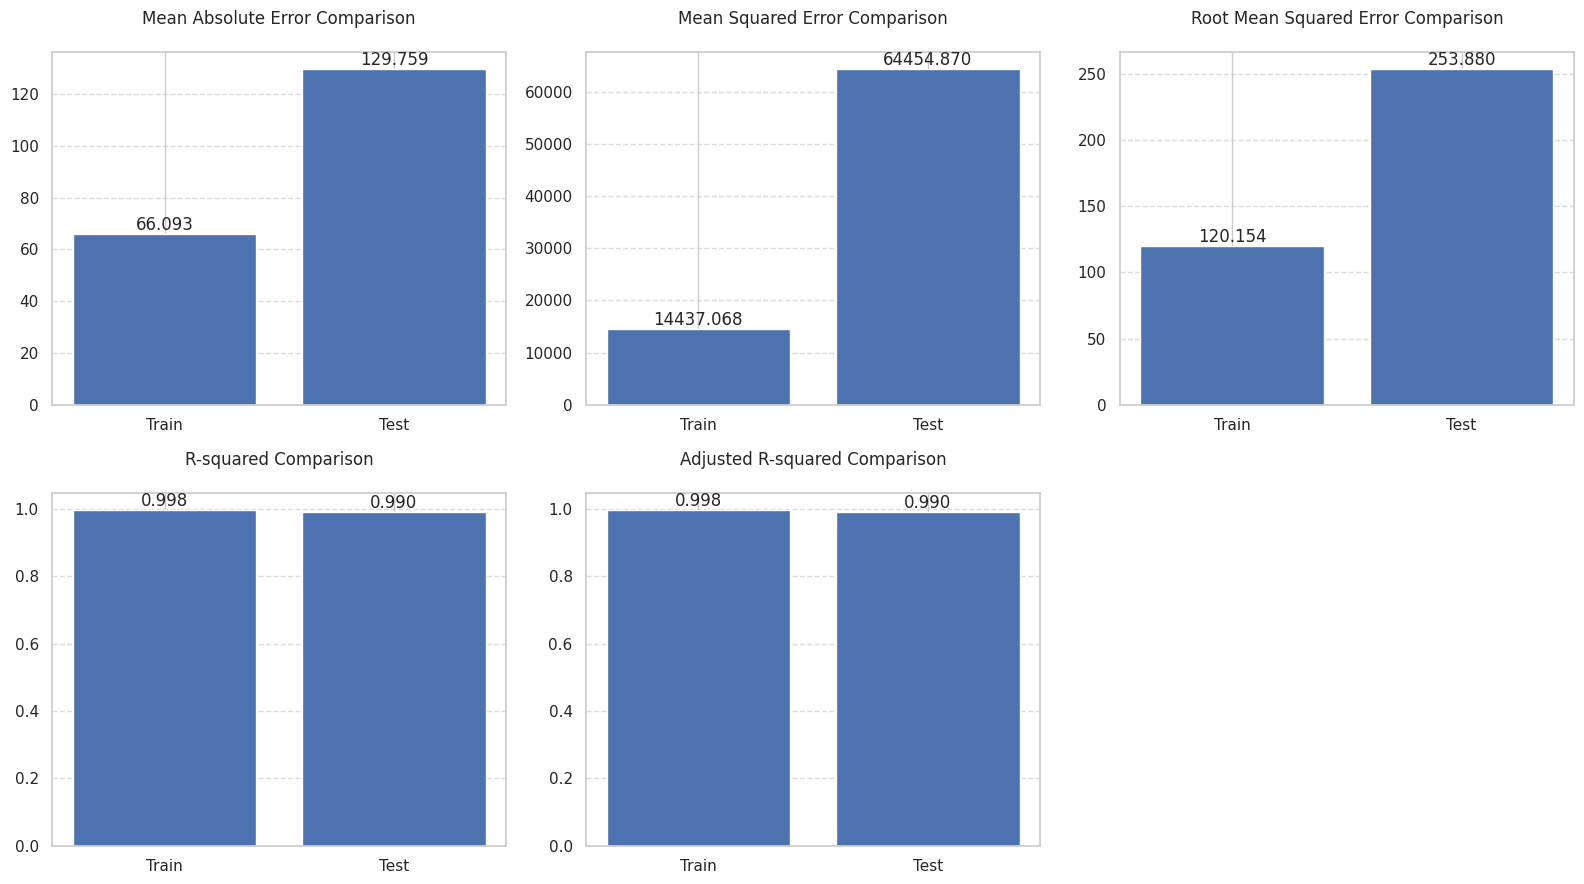

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
test_metrics = {
    'Mean Absolute Error': mae_test,
    'Mean Squared Error': mse_test,
    'Root Mean Squared Error': rmse_test,
    'R-squared': r2_test,
    'Adjusted R-squared': adj_r2_test
}

train_metrics = {
    'Mean Absolute Error': mae_train,
    'Mean Squared Error': mse_train,
    'Root Mean Squared Error': rmse_train,
    'R-squared': r2_train,
    'Adjusted R-squared': adj_r2_train
}

# Create subplots for each metric
metrics = list(test_metrics.keys())
fig, axes = plt.subplots(2, 3, figsize=(16, 9)) # 2x3 grid  
axes = axes.ravel()

# Create a bar plot for each metric
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Create bars
    x = np.arange(2)
    values = [train_metrics[metric], test_metrics[metric]]
    
    bars = ax.bar(x, values)
    
    # Customize the plot
    ax.set_title(f'{metric} Comparison', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(['Train', 'Test'])
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    # Add grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to start from 0
    ax.set_ylim(bottom=0)

# Remove the empty subplot
axes[-1].remove()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [84]:
# Get the results from the grid search
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,param_model__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,5.910391,0.160202,0.303450,0.014941,0.1,0.01,3,1000,0.8,hist,"{'model__gamma': 0.1, 'model__learning_rate': ...",-2.813003,-2.772746,-2.765681,-2.790825,-2.785564,0.018305,89
1,6.286829,0.188980,0.262212,0.023414,0.1,0.01,3,1000,0.8,auto,"{'model__gamma': 0.1, 'model__learning_rate': ...",-2.813003,-2.772746,-2.765681,-2.790825,-2.785564,0.018305,89
2,6.145449,0.260358,0.281696,0.038025,0.1,0.01,3,1000,1,hist,"{'model__gamma': 0.1, 'model__learning_rate': ...",-2.834942,-2.804907,-2.799015,-2.824385,-2.815812,0.014496,93
3,6.168544,0.140056,0.298393,0.031844,0.1,0.01,3,1000,1,auto,"{'model__gamma': 0.1, 'model__learning_rate': ...",-2.834942,-2.804907,-2.799015,-2.824385,-2.815812,0.014496,93
4,61.757909,0.467122,2.159315,0.108628,0.1,0.01,3,10000,0.8,hist,"{'model__gamma': 0.1, 'model__learning_rate': ...",-0.539067,-0.487374,-0.508766,-0.516073,-0.512820,0.018462,65


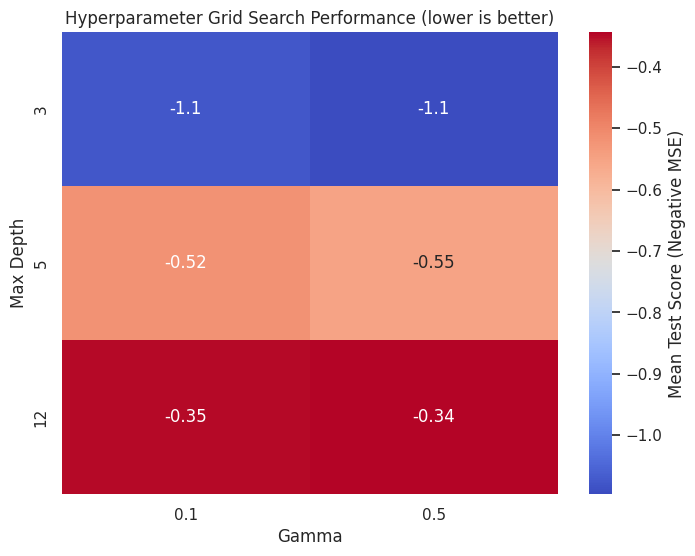

In [85]:
# Plot a heatmap of the performance (negative MSE) vs. two hyperparameters
heatmap_data = results.pivot_table(
    values='mean_test_score', 
    index='param_model__max_depth', 
    columns='param_model__gamma'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean Test Score (Negative MSE)'})
plt.title("Hyperparameter Grid Search Performance (lower is better)")
plt.xlabel('Gamma')
plt.ylabel('Max Depth')
plt.show()


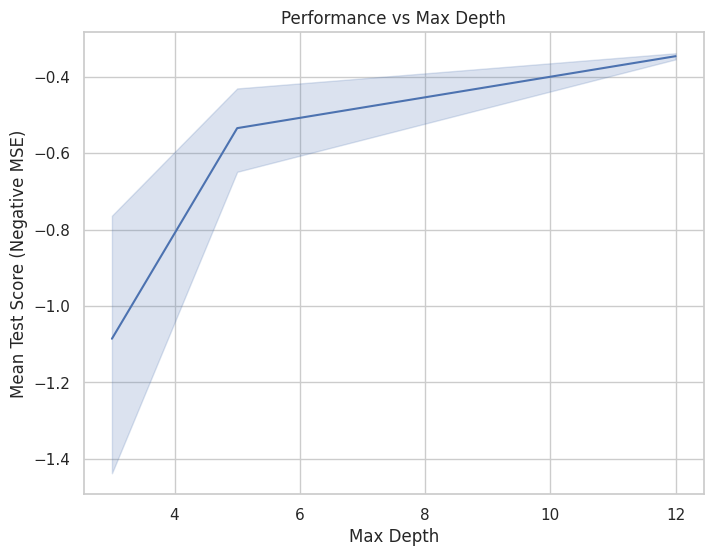

In [86]:
# Plot performance vs max_depth
plt.figure(figsize=(8, 6))
sns.lineplot(data=results, x='param_model__max_depth', y='mean_test_score')
plt.title("Performance vs Max Depth")
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (Negative MSE)')
plt.grid(True)
plt.show()

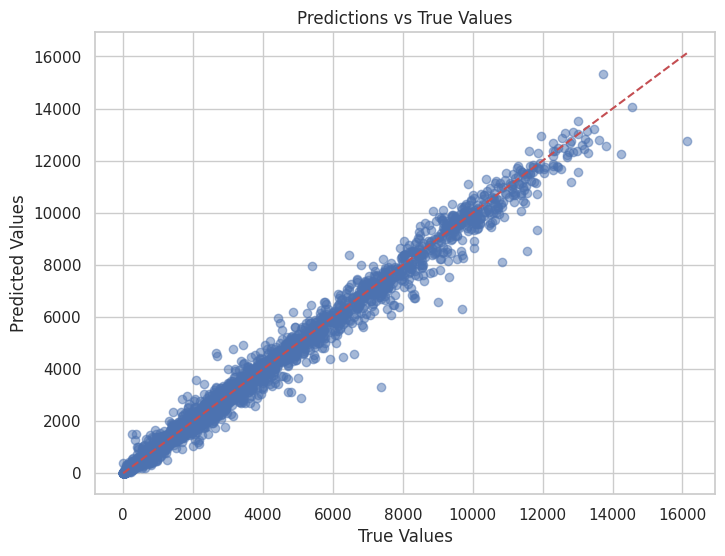

In [90]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_transformed, y_test_pred_transformed, alpha=0.5)
plt.plot(
    [min(y_test_transformed), max(y_test_transformed)],
    [min(y_test_transformed), max(y_test_transformed)],
    "r--",
)
plt.title("Predictions vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

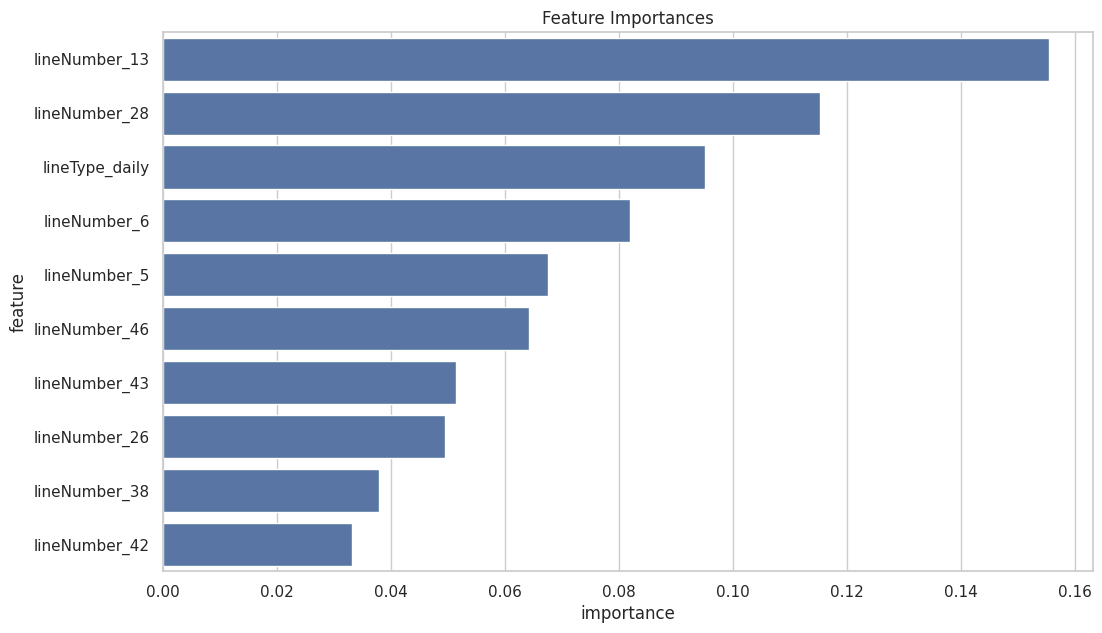

In [91]:
df_processed = preprocessor.fit_transform(X)
# display the feature importances
feature_importances = model.named_steps["model"].feature_importances_
feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out()
feature_names = np.concatenate([numerical_features, feature_names])

feature_importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importances}
).sort_values("importance", ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x="importance", y="feature", data=feature_importance_df[:10])
plt.title("Feature Importances")
plt.show()